In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import defaultdict

This notebook is used to compare different embedding methods. 

Dataset: https://github.com/Seeliglab/2017---Deep-learning-yeast-UTRs  
Except the deep learning method, we only use 1,000 data points to do experiments, in order to simulate the case with limited data. 

Methods:  
A. one-hot encoding  
B. ngrams (kmers) embedding  
C. kernels   
D. unsurpervised embedding  

Evaluation:  
A. reconstruction error?  
B. downstream task (regression)

In [2]:
df = pandas.read_csv('~/git/2017---Deep-learning-yeast-UTRs/Data/Random_UTRs.csv.gz', compression='gzip', delimiter=',')

In [3]:
mask = df['UTR'].str.len() >= 6
df = df.loc[mask]

#df['UTR_length'] = df['UTR'].apply(len)
df['RBS'] = df['UTR'].str[-5:]

In [4]:
df.head()

,Unnamed: 0,UTR,growth_rate,t0,t1,RBS
0,0,AAAAAAAAAACATAATAACGATGATCAGTTAAAATCATAGTCTAAG...,-1.237065,14,3,GCCAT
1,1,AAAAAAAAAAGACTACAACAGATTGTAGTGGCGGACCAGTGTGCCT...,1.288663,14,49,TTACA
2,2,AAAAAAAAAATATGGGGCCCTGTTCCAAAGATACCTCAATTTCATA...,-0.608457,13,6,AATAA
3,3,AAAAAAAAAATCTCTGGCCCGATTATACTGGAGCTAATGTAAAATT...,-1.093964,12,3,TTGTT
4,4,AAAAAAAAACATAAATATGAAGGCCTGACATTATAAATAACTTACC...,-0.048841,7,6,CTATG


In [5]:
# UTR sequence is unrepeated 
assert len(df.UTR.unique()) == len(df)

# RBS has all combinations 
assert len(df.RBS.unique()) == 4 ** 5

In [6]:
raw_X = np.asarray(df['RBS'])
raw_Y = np.asarray(df['growth_rate'])

small_raw_X = raw_X[:5000]
small_raw_Y = raw_Y[:5000]

### independence test

In [7]:
def distance_arms(arm1, arm2):
    assert len(arm1) == len(arm2)
    distance = 0
    for idx in range(len(arm1)):
        if arm1[idx] != arm2[idx]:
            distance += 1
        
    return distance

def chisquare_arms(arm1, arm2):
    return chisquare(rewards_dict[arm1], rewards_dict[arm2])

def abs_diff(arm1, arm2):
    #return np.abs(np.mean(rewards_dict[arm1]) - np.mean(rewards_dict[arm2]))
    r1 = np.mean(rewards_dict[arm1])
    r2 = np.mean(rewards_dict[arm2])
    if r1 < r2:
        return r1/r2
    else:
        return r2/r1
    
from scipy.stats import chisquare

distance_dict = {} # keys: (arm1, arm2), values: (distance of arms, chisquare of arms)
new_dict = defaultdict(list) # keys: distances, values: sequences of scores

distance_list = []
score_list = []

for i, arm_i in enumerate(small_raw_X):
    for j, arm_j in enumerate(small_raw_X):
        if j > i:
            distance = distance_arms(arm_i, arm_j)
            #score = abs_diff(arm_i, arm_j)
            score = np.abs(float(small_raw_Y[i]) - float(small_raw_Y[j]))
            distance_dict[(arm_i, arm_j)] = (distance, score)
            new_dict[distance].append(score)
            distance_list.append(distance)
            score_list.append(score)

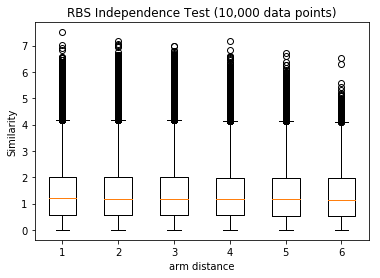

In [8]:
# if only use first 10,000 data points, there is no strong dependence

fig, ax = plt.subplots()

new_list = []

for key, value in new_dict.items():
    new_list.append(value)
ax.boxplot(new_list)

plt.title('RBS Independence Test (10,000 data points)')
plt.xlabel('arm distance')
plt.ylabel('Similarity')
#plt.savefig('RBS_Independence_Test.png')

### One-hot encoding

In [9]:
# use code from https://github.com/Seeliglab/2017---Deep-learning-yeast-UTRs 

# one hot encoding of UTRs
# X = one hot encoding matrix
# Y = growth rates

def one_hot_encoding(X):
    
    bases = ['A','C','G','T']
    base_dict = dict(zip(bases,range(4))) # {'A' : 0, 'C' : 1, 'G' : 2, 'T' : 3}

    n = X.shape[0]
    d = len(X[0])
    
    # initialize an empty numpy ndarray of the appropriate size
    new_X = np.zeros((n, d * 4))
    
    # loop through the array of sequences to create a feature array 
    for i in range(n):
        seq = X[i]
        
        # loop through each individual sequence, from the 5' to 3' end
        for b in range(d):
            # this will assign a 1 to the appropriate base and position for this UTR sequence
            new_X[i, b * 4 + base_dict[seq[b]]] = 1.
    
    return new_X

In [10]:
small_X = one_hot_encoding(small_raw_X)
small_Y = small_raw_Y
X_train, X_test, y_train, y_test = train_test_split(small_X, small_Y, test_size=0.2, random_state=42)

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Model initialization
regression_model = LinearRegression()
# Fit the data(train the model)
regression_model.fit(X_train, y_train)
# Predict
y_predicted = regression_model.predict(X_test)

# model evaluation
rmse = mean_squared_error(y_test, y_predicted)
r2 = r2_score(y_test, y_predicted)

# printing values
# print('Slope:' ,regression_model.coef_)
# print('Intercept:', regression_model.intercept_)
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)


Root mean squared error:  1.388236020655902
R2 score:  0.025610480488952314


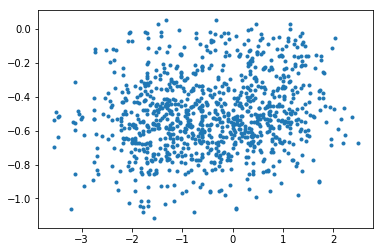

In [12]:
plt.plot(y_test, y_predicted, '.')

Root mean squared error:  1.388236020655902
R2 score:  0.025610480488952314


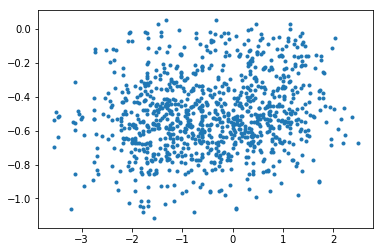

In [13]:
from sklearn.kernel_ridge import KernelRidge

clf = KernelRidge(alpha=1.0, kernel = 'rbf')
clf.fit(X_train, y_train) 
y_predict = clf.predict(X_test)

# model evaluation
rmse = mean_squared_error(y_test, y_predicted)
r2 = r2_score(y_test, y_predicted)

# printing values
# print('Slope:' ,regression_model.coef_)
# print('Intercept:', regression_model.intercept_)
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)

plt.plot(y_test, y_predicted, '.')

### ngrams

In [14]:
def generate_ngrams(s, n):
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = zip(*[s[i:] for i in range(n)])
    return ["".join(ngram) for ngram in ngrams]

features = zip(*[generate_ngrams(df['UTR'][0], i) for i in range(1,7)])